# Diabetes Readmission Project: Data Exploration and Preprocessing

This project focuses on data from 130 US hospitals to predict early readmission in diabetic patients within 30 days. The project workflow includes:
1. Data Exploration and Clustering
2. Data Preprocessing and Feature Engineering
3. Algorithm Selection and Model Training
4. Result Analysis
5. Visualization
6. Web Integration


## Step 1: Importing Libraries

In [44]:
pip install dash flask plotly requests scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\orkha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [45]:
import pandas as pd
import numpy as np
import requests
from flask import Flask, request, jsonify
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Step 2 Data Loading and Initial Exploration

In this section, we load the diabetic patient dataset and perform preliminary exploratory data analysis. We begin by examining the shape of the dataset, checking for missing values, and understanding the data types present. This helps in identifying any potential issues or areas that require further cleaning.

### Key Findings:
- **Shape of the Dataset**: The dataset contains a specific number of rows and columns, indicating the total number of patients and features recorded.
- **Missing Values**: A count of missing values for each feature is presented, providing insights into data completeness.
- **Data Types**: The data types of each feature are analyzed to inform subsequent processing steps.

### Basic Statistical Summary
We compute basic statistics for all features, which include measures of central tendency and dispersion for numerical columns, along with counts and unique values for categorical columns. This analysis aids in understanding the general distribution and characteristics of the data.

## Clustering Analysis

To identify distinct segments of patients within the dataset, we conduct a clustering analysis using the KMeans algorithm. 

1. **Data Preparation**: We replace placeholder values (`'?'`) with `NaN` to facilitate accurate analysis. Then, we isolate numeric features, filling any missing values with zeros.
2. **KMeans Clustering**: The KMeans algorithm is applied to categorize patients into three distinct clusters based on their numerical attributes.

### Visualization of Clusters
The distribution of patients across the identified clusters is visualized using a count plot. This allows for a clear understanding of how many patients fall into each segment, which can be essential for targeted analysis or interventions.

Overall, this section of the code serves to prepare the data for more complex analyses and helps in uncovering underlying patterns in the patient population.


Diabetic Data Shape: (101766, 50)
Missing Values Count:
 encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide           

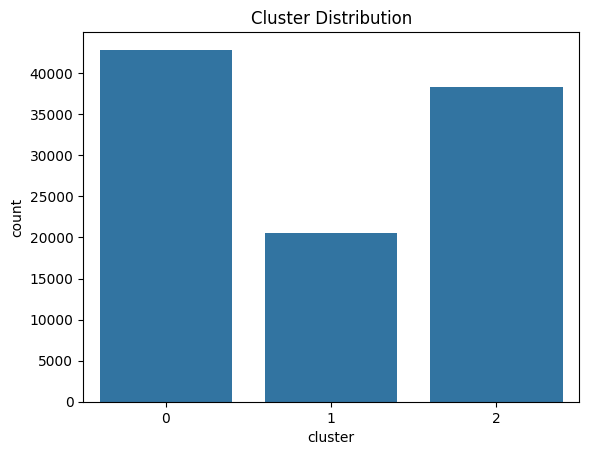

In [46]:
# Load datasets
diabetic_data = pd.read_csv('PRJ-002\diabetic_data.csv')
ids_mapping = pd.read_csv('PRJ-002\IDS_mapping.csv')

# Initial exploration
print("Diabetic Data Shape:", diabetic_data.shape)
print("Missing Values Count:\n", diabetic_data.isnull().sum())
print("Data Types:\n", diabetic_data.dtypes)

# Basic statistics
print("Basic Statistics:\n", diabetic_data.describe(include='all'))

# Clustering analysis to identify patient segments
# Replace '?' placeholders, and perform KMeans clustering on numeric data only
diabetic_data.replace('?', np.nan, inplace=True)
numeric_data = diabetic_data.select_dtypes(include=[np.number]).fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetic_data['cluster'] = kmeans.fit_predict(numeric_data)

# Visualize clusters
sns.countplot(data=diabetic_data, x='cluster')
plt.title("Cluster Distribution")
plt.show()


## Step 4: Data Preprocessing & Feature Engineering

Handling missing values, mapping categorical IDs, encoding features, and creating additional useful features.

## Replacing Placeholders (`?`) with `NaN`

Replacing any placeholders (`?`) in the dataset with `NaN` to ensure they are accurately recognized as missing values.

In [47]:
# Step: Replace '?' placeholders with NaN to standardize missing values
print("Replacing '?' placeholders with NaN...")

# Replaciung placeholders
diabetic_data.replace('?', np.nan, inplace=True)

# Checking for columns with missing values
missing_counts = diabetic_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Filter columns with missing values only

# Printing results of replacement
if missing_counts.empty:
    print("No missing values were found after replacement.")
else:
    print("Missing values were identified in the following columns after replacing placeholders:")
    print(missing_counts)

# Summary
print(f"\nTotal columns with missing values: {len(missing_counts)}")
print("Missing values replacement and reporting completed.\n")

Replacing '?' placeholders with NaN...
Missing values were identified in the following columns after replacing placeholders:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64

Total columns with missing values: 9
Missing values replacement and reporting completed.



## Step 4.1: Handling Missing Values

After identifying the columns with missing values, we need to address these gaps. We'll handle each column based on the type of data and the proportion of missing entries:

1. **High missingness (e.g., `weight, max_glu_serum, A1Cresult`)**: Considering dropping if the column has more than 90% missing values.
2. **Categorical Columns (e.g., `race`, `payer_code`, `medical_specialty`)**: Imputing with the most frequent (mode) value.
3. **Diagnostic Codes (e.g., `diag_1`, `diag_2`, `diag_3`)**: Imputing with the most frequent value or consider grouping similar diagnoses.

In [48]:
# Dropping weight, max_glu_serum, A1Cresult column due to high missingness (over 90% missing) if they exist in the dataset
columns_to_drop = ['weight', 'max_glu_serum', 'A1Cresult']
existing_columns_to_drop = [col for col in columns_to_drop if col in diabetic_data.columns]
diabetic_data.drop(columns=existing_columns_to_drop, inplace=True)
print("Dropped columns with high missingness:", existing_columns_to_drop)

# Imputing categorical columns with the most frequent (mode) value
categorical_columns_to_impute = ['race', 'payer_code', 'medical_specialty']
for column in categorical_columns_to_impute:
    if column in diabetic_data.columns:  # Ensure the column exists before trying to impute
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Imputing diagnosis codes with the most frequent value (low missingness columns)
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
for column in diagnosis_columns:
    if column in diabetic_data.columns:  # Ensure the column exists before trying to impute
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Verifying that there are no remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll the missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider doing something about it.")


# Verifying that there are no remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider doing something about it.")

    

Dropped columns with high missingness: ['weight', 'max_glu_serum', 'A1Cresult']
Filled missing values in 'race' with the most frequent value: Caucasian
Filled missing values in 'payer_code' with the most frequent value: MC
Filled missing values in 'medical_specialty' with the most frequent value: InternalMedicine
Filled missing values in 'diag_1' with the most frequent value: 428
Filled missing values in 'diag_2' with the most frequent value: 276
Filled missing values in 'diag_3' with the most frequent value: 250

All the missing values have been successfully handled.


C:\Users\orkha\AppData\Local\Temp\ipykernel_4324\1166344030.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetic_data[column].fillna(mode_value, inplace=True)
C:\Users\orkha\AppData\Local\Temp\ipykernel_4324\1166344030.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F


All missing values have been successfully handled.


## 4.2 Verify No Remaining Missing Values!!!!
We are going to check if any columns still contain missing values after the cleaning process.

In [49]:
# Check for remaining missing values in the dataset
remaining_missing_counts = diabetic_data.isnull().sum()
remaining_missing_counts = remaining_missing_counts[remaining_missing_counts > 0]

if remaining_missing_counts.empty:
    print("No remaining missing values.")
else:
    print("Columns with remaining missing values:")
    print(remaining_missing_counts)

No remaining missing values.


## 4.3 Confirm Data Types for Each Column
Ensuring that each column has the correct data type is essential for successful analysis and modeling.

In [50]:
# Display data types of each column
print("Data Types Before Adjustment:\n", diabetic_data.dtypes)

# Example: Convert 'encounter_id' and 'patient_nbr' to strings if they're not identifiers
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype(str)
diabetic_data['patient_nbr'] = diabetic_data['patient_nbr'].astype(str)

# Optional conversions for dates, booleans, or other expected types
# e.g., Convert 'age' to an ordinal category or numerical range if needed.

print("\nData Types After Adjustment:\n", diabetic_data.dtypes)

Data Types Before Adjustment:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide               

## 4.4 Adjust Data Types of Identifier Columns
## Convert encounter_id and patient_nbr to str if they represent unique identifiers rather than numerical values

In [51]:
# Convert encounter_id and patient_nbr to string as they are identifiers
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype(str)
diabetic_data['patient_nbr'] = diabetic_data['patient_nbr'].astype(str)
print("Converted 'encounter_id' and 'patient_nbr' to string type.")

Converted 'encounter_id' and 'patient_nbr' to string type.


## 4.5 Age Transformation. Converting age into numeric values by taking the midpoint of each range.


In [52]:
# Create bins for age ranges
# Convert age range to midpoint integer for numeric analysis
diabetic_data['age'] = diabetic_data['age'].str.extract('(\d+)-(\d+)').astype(int).mean(axis=1)
print("Converted 'age' to numeric midpoints.")



Converted 'age' to numeric midpoints.


## 4.6 Ensure Numeric Columns Are Properly Typed Confirm that columns intended to be numeric (e.g., time_in_hospital, num_lab_procedures) have the correct data type.

In [53]:
# List of columns expected to be numeric for verification
numeric_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# Check if any are not numeric
non_numeric_columns = diabetic_data[numeric_columns].select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print(f"Warning: The following expected numeric columns are not numeric: {list(non_numeric_columns)}")
else:
    print("All expected numeric columns are correctly typed.")


All expected numeric columns are correctly typed.


## First we run Unique Values: The unique values for each column that we suspect might be categorical
## 4.7 Encode Categorical Variables
## 4.8 Check the data types again to ensure all transformations have been applied correctly

In [54]:
for column in diabetic_data.columns:
    print(f"{column}: {diabetic_data[column].unique()}")


encounter_id: ['2278392' '149190' '64410' ... '443854148' '443857166' '443867222']
patient_nbr: ['8222157' '55629189' '86047875' ... '140199494' '120975314' '175429310']
race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male' 'Unknown/Invalid']
age: [ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
admission_type_id: [6 1 2 3 4 5 8 7]
discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code: ['MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: ['Pediatrics-Endocrinology' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neur

In [55]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming diabetic_data is already defined and cleaned

# Step 1: Print the current columns to verify what exists
print("Current columns in the DataFrame:\n", diabetic_data.columns.tolist())

# One-hot encoding for categorical variables
categorical_columns = ['race', 'gender', 'payer_code', 'medical_specialty', 'readmitted']

# Check which of the categorical columns are actually in the DataFrame
missing_columns = [col for col in categorical_columns if col not in diabetic_data.columns]
if missing_columns:
    print(f"Missing columns for one-hot encoding: {missing_columns}")
else:
    diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_columns, drop_first=True)
    print("Encoded categorical columns into numeric format using one-hot encoding.")

# Print the columns again to confirm changes
print("Columns in the DataFrame after one-hot encoding:\n", diabetic_data.columns.tolist())

# Check if 'age_group' exists; if not, create it
if 'age_group' not in diabetic_data.columns:
    # Create age groups based on numerical 'age' column
    age_bins = [0, 30, 50, 70, 90, 100]
    age_labels = ['<30', '30-49', '50-69', '70-89', '90+']
    diabetic_data['age_group'] = pd.cut(diabetic_data['age'], bins=age_bins, labels=age_labels, right=False)
    print("Created 'age_group' from 'age' ranges.")

# Label encoding for ordinal categorical variables
print("*******************************************************************")

# Create a label encoder instance
label_encoder = LabelEncoder()

# Check if 'age_group' exists before encoding
if 'age_group' in diabetic_data.columns:
    diabetic_data['age_group'] = label_encoder.fit_transform(diabetic_data['age_group'].astype(str))
else:
    print("'age_group' column is missing, unable to encode.")

# Label encode 'readmitted'
if 'readmitted' in diabetic_data.columns:
    diabetic_data['readmitted'] = label_encoder.fit_transform(diabetic_data['readmitted'])
else:
    print("'readmitted' column is missing, unable to encode.")

print("Encoded 'age_group' and 'readmitted' using label encoding.")

print("*******************************************************************")

# Check the final data types
print("Final Data Types:\n", diabetic_data.dtypes)

# Optionally, check the structure of the transformed dataset
print("Final DataFrame Structure:\n")
print(diabetic_data.info())
print("\nPreview of the dataset:\n", diabetic_data.head())


Current columns in the DataFrame:
 ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'cluster']
Encoded categorical columns into numeric format using one-hot encoding.
Columns in the DataFrame after one-hot encoding:
 ['encounter_id', 'patient_nbr', 'age', 'admission_type

In [56]:
# CHECKPOINT 
# Drop the 'encounter_id' and 'patient_nbr' columns
diabetic_data = diabetic_data.drop(columns=['encounter_id', 'patient_nbr'])
# Check the structure of the DataFrame
print("Final DataFrame Structure:")
print(diabetic_data.info())

# Check descriptive statistics of the DataFrame
print("\nDescriptive Statistics:")
print(diabetic_data.describe(include='all'))

# Optionally, check for missing values
print("\nMissing Values Count:")
print(diabetic_data.isnull().sum())


Final DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Columns: 137 entries, age to age_group
dtypes: bool(95), float64(1), int32(1), int64(12), object(28)
memory usage: 41.4+ MB
None

Descriptive Statistics:
                  age  admission_type_id  discharge_disposition_id  \
count   101766.000000      101766.000000             101766.000000   
unique            NaN                NaN                       NaN   
top               NaN                NaN                       NaN   
freq              NaN                NaN                       NaN   
mean        65.967022           2.024006                  3.715642   
std         15.940838           1.445403                  5.280166   
min          5.000000           1.000000                  1.000000   
25%         55.000000           1.000000                  1.000000   
50%         65.000000           1.000000                  1.000000   
75%         75.000000           3.000000 

# Ensure that all categorical features are appropriately encoded
# Check for Multicollinearity:
# Feature Scaling

Unique values in 'diag_1': ['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189' '786' '427' '996'
 '277' '584' '462' '473' '411' '174' '486' '998' '511' '432' '626' '295'
 '196' '250.6' '618' '182' '845' '423' '808' '250.4' '722' '403' '250.11'
 '784' '707' '440' '151' '715' '997' '198' '564' '812' '38' '590' '556'
 '578' '250.32' '433' 'V58' '569' '185' '536' '255' '250.13' '599' '558'
 '574' '491' '560' '244' '250.03' '577' '730' '188' '824' '250.8' '332'
 '562' '291' '296' '510' '401' '263' '438' '70' '250.02' '493' '642' '625'
 '571' '738' '593' '250.42' '807' '456' '446' '575' '250.41' '820' '515'
 '780' '250.22' '995' '235' '250.82' '721' '787' '162' '724' '282' '514'
 'V55' '281' '250.33' '530' '466' '435' '250.12' 'V53' '789' '566' '822'
 '191' '557' '733' '455' '711' '482' '202' '280' '553' '225' '154' '441'
 '250.81' '349' '962' '592' '507' '386' '156' '200' '728' '348' '459'
 '426' '388' '607' '337' '82'

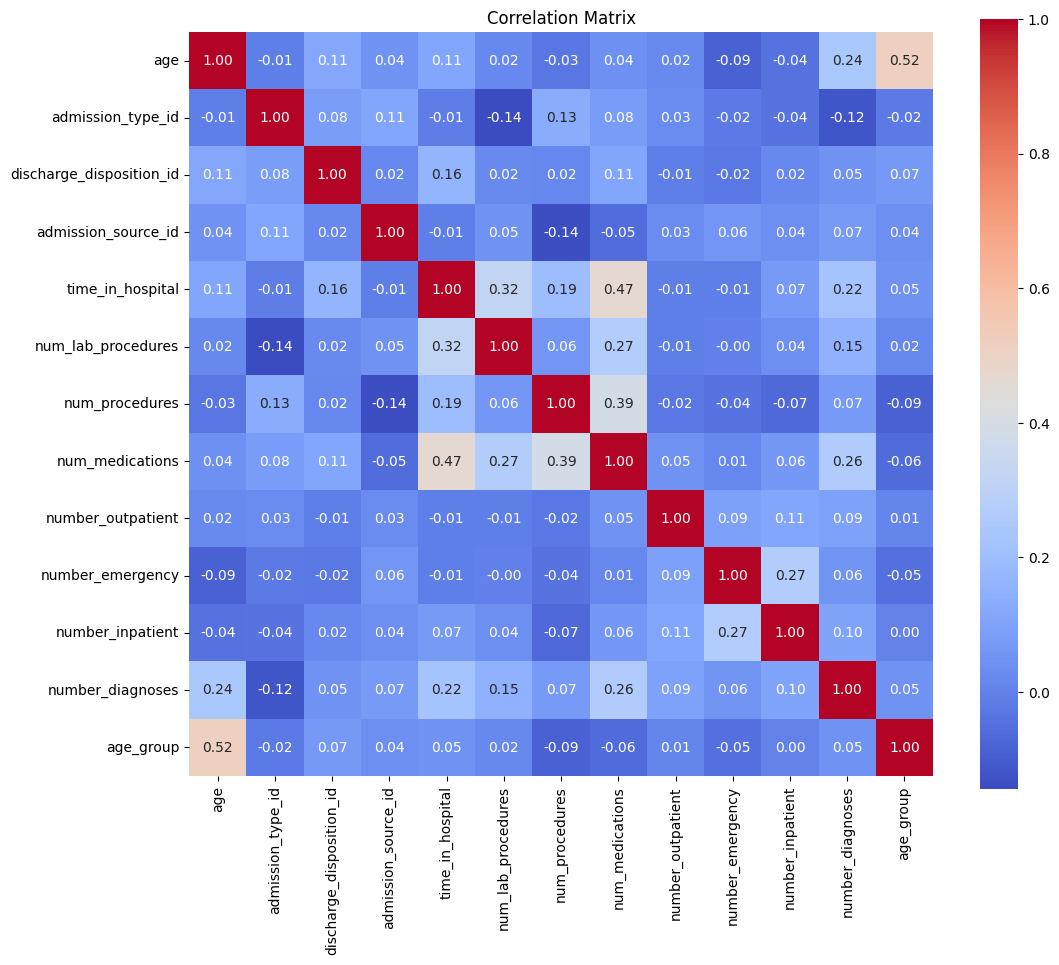

^***************************************************************


In [59]:
for col in diabetic_data.select_dtypes(include='object').columns:
    print(f"Unique values in '{col}': {diabetic_data[col].unique()}")
print("^***************************************************************")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the correlation matrix on numeric columns only
numeric_data = diabetic_data.select_dtypes(include=['float64', 'int64'])  # Include float and int types
corr = numeric_data.corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

print("^***************************************************************")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
diabetic_data[['age']] = scaler.fit_transform(diabetic_data[['age']])

